# Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Load Dataset

In [2]:
def fetch_iwm_data():
    iwm = yf.Ticker("IWM")
    data = iwm.history(period="max")  # Adjust the period as needed
    return data

In [3]:
iwm_data = fetch_iwm_data()

In [4]:
iwm_data['Target'] = (iwm_data['High'] >= 1.01 * iwm_data['Open']).astype(int)

In [5]:
iwm_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Target
Date,,,,,,,,,
2000-05-26 00:00:00-04:00,33.261807,33.398781,33.102004,33.398781,74800,0.0,0.0,0.0,0
2000-05-30 00:00:00-04:00,33.878194,34.631550,33.878194,34.631550,57600,0.0,0.0,0.0,1
2000-05-31 00:00:00-04:00,34.745700,35.202279,34.745700,34.757114,36000,0.0,0.0,0.0,1
2000-06-01 00:00:00-04:00,35.470514,35.544708,35.470514,35.544708,7000,0.0,0.0,0.0,0
2000-06-02 00:00:00-04:00,37.154140,37.393845,37.154140,37.393845,29400,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
2024-04-26 00:00:00-04:00,197.000000,198.889999,196.419998,198.360001,24613600,0.0,0.0,0.0,0
2024-04-29 00:00:00-04:00,199.250000,200.410004,198.880005,199.960007,20494600,0.0,0.0,0.0,0
2024-04-30 00:00:00-04:00,198.110001,198.649994,195.750000,195.899994,30606800,0.0,0.0,0.0,0


In [6]:
iwm_data.index

DatetimeIndex(['2000-05-26 00:00:00-04:00', '2000-05-30 00:00:00-04:00',
               '2000-05-31 00:00:00-04:00', '2000-06-01 00:00:00-04:00',
               '2000-06-02 00:00:00-04:00', '2000-06-05 00:00:00-04:00',
               '2000-06-06 00:00:00-04:00', '2000-06-07 00:00:00-04:00',
               '2000-06-08 00:00:00-04:00', '2000-06-09 00:00:00-04:00',
               ...
               '2024-04-19 00:00:00-04:00', '2024-04-22 00:00:00-04:00',
               '2024-04-23 00:00:00-04:00', '2024-04-24 00:00:00-04:00',
               '2024-04-25 00:00:00-04:00', '2024-04-26 00:00:00-04:00',
               '2024-04-29 00:00:00-04:00', '2024-04-30 00:00:00-04:00',
               '2024-05-01 00:00:00-04:00', '2024-05-02 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=6021, freq=None)

In [7]:
iwm_data = iwm_data.reset_index()

# Visualizing Trade v/s No Trade

Class Distribution:
Target
0    0.698555
1    0.301445
Name: proportion, dtype: float64


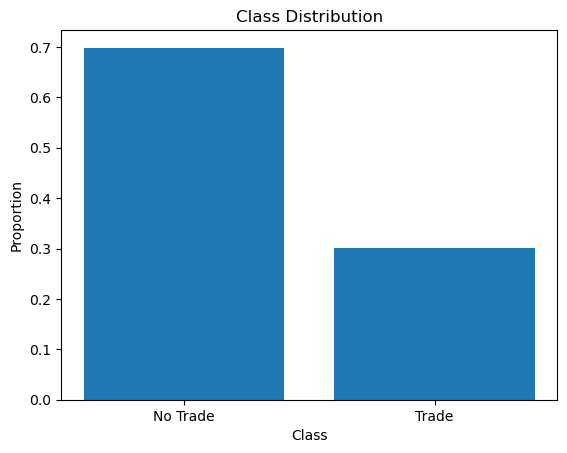

In [8]:
# Calculate the distribution of the target variable
target_distribution = iwm_data['Target'].value_counts(normalize=True)

# Print the distribution
print("Class Distribution:")
print(target_distribution)

# Visualize the distribution

plt.bar(target_distribution.index, target_distribution.values)
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.title('Class Distribution')
plt.xticks([0, 1], ['No Trade', 'Trade'])
plt.show()

# Adding Macro Economic features

In [9]:
from fredapi import Fred

# Setup FRED API
api_key = ''  # Replace this with your actual FRED API key
fred = Fred(api_key=api_key)

# Function to fetch data from FRED
def fetch_fred_series(series_id, start_date, end_date):
    data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
    return data

# Load your ETF data
# file_path = 'IWM_2001-2024.csv'
# iwm_data = pd.read_csv(file_path)
# iwm_data['Date'] = pd.to_datetime(iwm_data['Date'])

# Create a YearMonth column for merging
iwm_data['YearMonth'] = iwm_data['Date'].dt.to_period('M')

# Define the date range based on your dataset
start_date = iwm_data['Date'].min().strftime('%Y-%m-%d')
end_date = iwm_data['Date'].max().strftime('%Y-%m-%d')

# Fetch and prepare economic data
def prepare_and_fetch(series_id, value_name):
    data = fetch_fred_series(series_id, start_date, end_date)
    df = data.reset_index()
    df.columns = ['Date', value_name]
    df['YearMonth'] = pd.to_datetime(df['Date']).dt.to_period('M')
    return df[['YearMonth', value_name]]

# Prepare all dataframes
interest_rate_df = prepare_and_fetch('FEDFUNDS', 'Interest Rate')
cpi_df = prepare_and_fetch('CPIAUCSL', 'CPI')
gdp_df = prepare_and_fetch('GDP', 'GDP')
unemployment_df = prepare_and_fetch('UNRATE', 'Unemployment Rate')

# Merge all data into one DataFrame
from functools import reduce

dfs = [iwm_data, interest_rate_df, cpi_df, gdp_df, unemployment_df]
merged_data = reduce(lambda left, right: pd.merge(left, right, on='YearMonth', how='left'), dfs)

# Drop the YearMonth column if no longer needed
merged_data.drop(columns=['YearMonth'], inplace=True)

print(merged_data.head())


/var/folders/7x/m3qhq43x4c18t73z0bvm4xfm0000gn/T/ipykernel_15690/170131911.py:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  iwm_data['YearMonth'] = iwm_data['Date'].dt.to_period('M')


                       Date       Open       High        Low      Close  \
0 2000-05-26 00:00:00-04:00  33.261807  33.398781  33.102004  33.398781   
1 2000-05-30 00:00:00-04:00  33.878194  34.631550  33.878194  34.631550   
2 2000-05-31 00:00:00-04:00  34.745700  35.202279  34.745700  34.757114   
3 2000-06-01 00:00:00-04:00  35.470514  35.544708  35.470514  35.544708   
4 2000-06-02 00:00:00-04:00  37.154140  37.393845  37.154140  37.393845   

   Volume  Dividends  Stock Splits  Capital Gains  Target  Interest Rate  \
0   74800        0.0           0.0            0.0       0           6.27   
1   57600        0.0           0.0            0.0       1           6.27   
2   36000        0.0           0.0            0.0       1           6.27   
3    7000        0.0           0.0            0.0       0           6.53   
4   29400        0.0           0.0            0.0       0           6.53   

     CPI  GDP  Unemployment Rate  
0  171.2  NaN                4.0  
1  171.2  NaN         

In [10]:
iwm_data = merged_data
iwm_data.set_index('Date', inplace = True)

In [11]:
iwm_data.isnull().sum()

Open                    0
High                    0
Low                     0
Close                   0
Volume                  0
Dividends               0
Stock Splits            0
Capital Gains           0
Target                  0
Interest Rate           2
CPI                    24
GDP                  4025
Unemployment Rate      24
dtype: int64

In [12]:
# Filling NaN values

iwm_data = iwm_data.interpolate()
iwm_data['GDP'] = iwm_data['GDP'].interpolate(method='backfill')

In [13]:
iwm_data.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Volume               0
Dividends            0
Stock Splits         0
Capital Gains        0
Target               0
Interest Rate        0
CPI                  0
GDP                  0
Unemployment Rate    0
dtype: int64

# Creating Dataset

In [14]:
# Function to create input features and target variable with sliding window of n days
def create_sliding_window(data, n):
    X, y = [], []
    for i in range(len(data) - n):
        X.append(data.iloc[i:i+n].drop('Target', axis=1).values)
        y.append(data.iloc[i+n]['Target'])
    return np.array(X), np.array(y)

In [15]:
# Define window size
n_days = 3
num_trades = 10
# Create sliding window dataset
X, y = create_sliding_window(iwm_data[['Open', 'Close', 'High', 'Low', 'Volume', 'Target','Interest Rate', 'CPI', 'GDP',
       'Unemployment Rate']], n_days)


In [16]:
# Split the data into training, validation, and testing sets
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2


In [17]:
# Flatten the input data
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_val_scaled = scaler.transform(X_val_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Trade Decision Function

In [18]:
def trade_decision(predictions, threshold = 0.6):
    # Threshold for entering a trade
    

    # Make trading decisions based on predicted predictions
    trades = []
    for prediction in predictions:
        if prediction > threshold:
            trades.append(1)  # Enter trade
        else:
            trades.append(0)  # Do not enter trade

    return trades

# Neural Network Model

In [19]:
# Define the neural network model
nn_classifier = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
# Train the model
nn_classifier.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6884 - loss: 0.6197 - val_accuracy: 0.7101 - val_loss: 0.5838
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.7051 - loss: 0.5931 - val_accuracy: 0.7151 - val_loss: 0.5867
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.7020 - loss: 0.5915 - val_accuracy: 0.7234 - val_loss: 0.5655
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.7168 - loss: 0.5721 - val_accuracy: 0.7168 - val_loss: 0.5743
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.7144 - loss: 0.5717 - val_accuracy: 0.7201 - val_loss: 0.5733
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.7140 - loss: 0.5712 - val_accuracy: 0.7184 - val_loss: 0.5754
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.6979 - loss: 0.5894 - val_accuracy: 0.7184 - val_loss: 0.5705
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7215 - loss: 0.5639 - va

In [21]:
# Predict probabilities for the test set
nn_predictions = nn_classifier.predict(X_test_scaled)

# Threshold for entering a trade
# threshold = 0.6

# Make trading decisions based on predicted probabilities
nn_trades = trade_decision(nn_predictions)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


In [22]:
# Evaluate the model
accuracy_nn = np.mean(nn_trades == y_test)
print(f'Test Accuracy: {accuracy_nn}')

Test Accuracy: 0.7192691029900332


## Hyperparameter Tuning

In [23]:

# Define hyperparameters grid
batch_sizes = [32, 64, 128]
neurons = [64, 128, 256]
activation_functions = ['relu', 'tanh', 'sigmoid']

best_accuracy = 0
best_hyperparameters = {}
best_model = nn_classifier


In [24]:
# Iterate over hyperparameters
for batch_size in batch_sizes:
    for neuron in neurons:
        for activation_func in activation_functions:
            print(f"Case: Batch Size = {batch_size}, Neurons - {neuron}, Activation Function - {activation_func}")
            # Define the neural network model
            tuned_nn_classifier = Sequential([
                Dense(neuron, activation=activation_func, input_shape=(X_train_scaled.shape[1],)),
                Dense(neuron, activation=activation_func),
                Dense(neuron//2, activation=activation_func),
                Dense(1, activation='sigmoid')
            ])

            # Compile the model
            tuned_nn_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

            # Train the model
            tuned_nn_classifier.fit(X_train_scaled, y_train, epochs=10, batch_size=batch_size, validation_data=(X_val_scaled, y_val), verbose=0)

            # Predict probabilities for the test set
            tuned_nn_predictions = tuned_nn_classifier.predict(X_val_scaled)

            # Threshold for entering a trade
            # threshold = 0.6

            # Make trading decisions based on predicted probabilities
            tuned_nn_trades = trade_decision(tuned_nn_predictions)

            # Evaluate the model
            tuned_accuracy_nn = np.mean(tuned_nn_trades == y_val)
            # print(f'Test Accuracy: {nn_accuracy}')

            # Evaluate the model
            # nn_accuracy = nn_classifier.evaluate(X_test_scaled, y_test, verbose=0)[1]

            # Update best hyperparameters if accuracy improves
            if tuned_accuracy_nn > best_accuracy:
                best_accuracy = tuned_accuracy_nn
                best_hyperparameters = {'batch_size': batch_size, 'neurons': neuron, 'activation_func': activation_func}
                best_model = tuned_nn_classifier




Case: Batch Size = 32, Neurons - 64, Activation Function - relu
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step
Case: Batch Size = 32, Neurons - 64, Activation Function - tanh
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step
Case: Batch Size = 32, Neurons - 64, Activation Function - sigmoid
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
Case: Batch Size = 32, Neurons - 128, Activation Function - relu
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step
Case: Batch Size = 32, Neurons - 128, Activation Function - tanh
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
Case: Batch Size = 32, Neurons - 128, Activation Function - sigmoid
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
Case: Batch Size = 32, Neurons - 256, Activation Function - relu
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
Case: Batch Size = 32, Neurons - 256, Activation Function - tanh
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step
Case: Batch Size = 32, Neurons - 256, Activation Function - sigmoid
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
Case: Batch Size = 64, Neurons - 64, Act

In [25]:
print("Best Hyperparameters:", best_hyperparameters)
print("Best Validation Accuracy:", best_accuracy)

Best Hyperparameters: {'batch_size': 32, 'neurons': 256, 'activation_func': 'tanh'}
Best Validation Accuracy: 0.7109634551495017


In [26]:
tuned_nn_classifier = best_model

# Train the model with the best hyperparameters
# nn_classifier.fit(X_train_scaled, y_train, epochs=10, batch_size=best_hyperparameters['batch_size'], validation_data=(X_test_scaled, y_test))

# Predict probabilities for the test set
tuned_nn_predictions = tuned_nn_classifier.predict(X_test_scaled)

# Threshold for entering a trade
# threshold = 0.6

# Make trading decisions based on predicted probabilities
tuned_nn_trades = trade_decision(tuned_nn_predictions)

# Evaluate the model
tuned_accuracy_nn = np.mean(tuned_nn_trades == y_test)
print(f'Tuned Neural Network Test Accuracy: {tuned_accuracy_nn}')


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step
Tuned Neural Network Test Accuracy: 0.7101328903654485


# Random Forest Classifier

In [27]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [28]:
# Predict probabilities for the test set
rf_predictions = rf_classifier.predict_proba(X_test_scaled)[:, 1]

In [29]:
rf_trades = trade_decision(rf_predictions)

In [30]:
# Evaluate Random Forest
accuracy_rf = np.mean(rf_trades == y_test)
print(f'Random Forest Test Accuracy: {accuracy_rf}')

Random Forest Test Accuracy: 0.7109634551495017


## Hyperparameter Tuning

In [31]:
# Define the parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize Random Forest classifier
tuned_rf_classifier = RandomForestClassifier(random_state=42)

In [32]:

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=tuned_rf_classifier, param_grid=param_grid_rf, cv=5)
grid_search.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [33]:
# Get the best parameters and best model
best_params = grid_search.best_params_
best_rf_classifier = grid_search.best_estimator_



In [34]:
print(f"Best Random Forest params: {best_params}")

Best Random Forest params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [35]:
# Predict probabilities for the test set using the best model
tuned_rf_predictions = best_rf_classifier.predict_proba(X_test_flattened)[:, 1]

# Make trade decisions based on predictions
tuned_rf_trades = trade_decision(rf_predictions)

# Evaluate Random Forest
tuned_accuracy_rf = np.mean(tuned_rf_trades == y_test)
print(f'Tuned Random Forest Test Accuracy: {tuned_accuracy_rf}')

Tuned Random Forest Test Accuracy: 0.7109634551495017


# SVM

In [36]:
# Initialize SVM classifier
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train_scaled, y_train)

SVC(probability=True, random_state=42)

In [37]:
# Predict probabilities for the test set
svm_predictions = svm_classifier.predict_proba(X_test_scaled)[:, 1]

In [38]:
# Make trading decisions based on predicted probabilities
svm_trades = trade_decision(svm_predictions)

In [39]:
# Evaluate the model
accuracy_svm = np.mean(svm_trades == y_test)
print(f'SVM Test Accuracy: {accuracy_svm}')

SVM Test Accuracy: 0.7117940199335548


## Hyperparameter Tuning

In [40]:
# Define the parameter grid for hyperparameter tuning
param_grid_svm = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'gamma': [0.1, 0.01, 0.001]  # Kernel coefficient
}

# Initialize SVM classifier
tuned_svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)

In [41]:
# Perform grid search with cross-validation
grid_search_svm = GridSearchCV(estimator=tuned_svm_classifier, param_grid=param_grid_svm, cv=5)
grid_search_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001]})

In [42]:
# Get the best parameters and best model
best_params_svm = grid_search_svm.best_params_
best_svm_classifier = grid_search_svm.best_estimator_

In [43]:
print(f"Best SVM params: {best_params_svm}")

Best SVM params: {'C': 10, 'gamma': 0.1}


In [44]:
# Predict probabilities for the test set using the best model
tuned_svm_predictions = best_svm_classifier.predict_proba(X_test_scaled)[:, 1]

In [45]:
# Make trading decisions based on predicted probabilities
tuned_svm_trades = trade_decision(tuned_svm_predictions)

In [46]:
# Evaluate the tuned model
tuned_accuracy_svm = np.mean(tuned_svm_trades == y_test)
print(f'Tuned SVM Test Accuracy: {tuned_accuracy_svm}')

Tuned SVM Test Accuracy: 0.7159468438538206


# Logistic Regression

In [47]:
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [48]:
logistic_predictions = logistic_classifier.predict_proba(X_test_scaled)[:, 1]

In [49]:
logistic_trades = trade_decision(logistic_predictions)

In [50]:
accuracy_logistic = np.mean(logistic_trades == y_test)
print(f'Logistic Regression Test Accuracy: {accuracy_logistic}')

Logistic Regression Test Accuracy: 0.7043189368770764


## Hyperparameter Tuning

In [51]:
# Define the parameter grid for hyperparameter tuning
param_grid_logistic = {
    'C': [0.1, 1, 10],     # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Initialize Logistic Regression classifier
tuned_logistic_classifier = LogisticRegression(random_state=42)

In [52]:
# Perform grid search with cross-validation
grid_search_logistic = GridSearchCV(estimator=tuned_logistic_classifier, param_grid=param_grid_logistic, cv=5)
grid_search_logistic.fit(X_train_scaled, y_train)

/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']})

In [53]:
# Get the best parameters and best model
best_params_logistic = grid_search_logistic.best_params_
best_logistic_classifier = grid_search_logistic.best_estimator_


In [54]:
print(f"Best Logistic Regression params: {best_params_logistic}")

Best Logistic Regression params: {'C': 10, 'solver': 'liblinear'}


In [55]:
# Predict probabilities for the test set using the best model
tuned_logistic_predictions = best_logistic_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_logistic_trades = trade_decision(tuned_logistic_predictions)

# Evaluate the tuned model
tuned_accuracy_logistic = np.mean(tuned_logistic_trades == y_test)
print(f'Tuned Logistic Regression Test Accuracy: {tuned_accuracy_logistic}')

Tuned Logistic Regression Test Accuracy: 0.7101328903654485


# K-Nearest Neighbors

In [56]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [57]:
knn_predictions = knn_classifier.predict_proba(X_test_scaled)[:, 1]

In [58]:
knn_trades = trade_decision(knn_predictions)

In [59]:
accuracy_knn = np.mean(knn_trades == y_test)
print(f'KNN Test Accuracy: {accuracy_knn}')

KNN Test Accuracy: 0.7084717607973422


## Hyperparameter Tuning

In [60]:
# Define the parameter grid for hyperparameter tuning
param_grid_knn = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Initialize KNN classifier
tuned_knn_classifier = KNeighborsClassifier()

In [61]:
# Perform grid search with cross-validation
grid_search_knn = GridSearchCV(estimator=tuned_knn_classifier, param_grid=param_grid_knn, cv=5)
grid_search_knn.fit(X_train_scaled, y_train)


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [62]:

# Get the best parameters and best model
best_params_knn = grid_search_knn.best_params_
best_knn_classifier = grid_search_knn.best_estimator_

In [63]:
print(f"Best K-Nearest Neighbors params: {best_params_knn}")

Best K-Nearest Neighbors params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [64]:
# Predict probabilities for the test set using the best model
tuned_knn_predictions = best_knn_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_knn_trades = trade_decision(tuned_knn_predictions)

# Evaluate the tuned model
tuned_accuracy_knn = np.mean(tuned_knn_trades == y_test)
print(f'Tuned KNN Test Accuracy: {tuned_accuracy_knn}')

Tuned KNN Test Accuracy: 0.7009966777408638


# XGBoost

In [19]:
xgb_classifier = XGBClassifier(random_state=42)
xgb_classifier.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [20]:
xgb_predictions = xgb_classifier.predict_proba(X_test_scaled)[:, 1]

In [21]:
xgb_trades = trade_decision(xgb_predictions)

In [22]:
accuracy_xgb = np.mean(xgb_trades == y_test)
print(f'XGBoost Test Accuracy: {accuracy_xgb}')

XGBoost Test Accuracy: 0.7051495016611296


## Hyperparameter Tuning

In [69]:
# Define the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'max_depth': [3, 5, 7],           # Maximum tree depth
    'learning_rate': [0.1, 0.01, 0.001],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'gamma': [0, 0.1, 0.2],           # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.8, 0.9, 1.0],     # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 0.9, 1.0]  # Subsample ratio of columns when constructing each tree
}

# Initialize XGBoost classifier
tuned_xgb_classifier = XGBClassifier(random_state=42)

In [70]:
# Perform grid search with cross-validation
grid_search_xgb = GridSearchCV(estimator=tuned_xgb_classifier, param_grid=param_grid_xgb, cv=5)
grid_search_xgb.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]})

In [71]:
# Get the best parameters and best model
best_params_xgb = grid_search_xgb.best_params_
best_xgb_classifier = grid_search_xgb.best_estimator_

In [72]:
print(f"Best XGBoost params: {best_params_xgb}")

Best XGBoost params: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.9}


In [73]:
# Predict probabilities for the test set using the best model
tuned_xgb_predictions = best_xgb_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_xgb_trades = trade_decision(tuned_xgb_predictions)

# Evaluate the tuned model
tuned_accuracy_xgb = np.mean(tuned_xgb_trades == y_test)
print(f'Tuned XGBoost Test Accuracy: {tuned_accuracy_xgb}')

Tuned XGBoost Test Accuracy: 0.7134551495016611


# Gaussian Naive Bayes

In [74]:
gnb_classifier = GaussianNB()
gnb_classifier.fit(X_train_scaled, y_train)

GaussianNB()

In [75]:
gnb_predictions = gnb_classifier.predict_proba(X_test_scaled)[:, 1]


In [76]:
gnb_trades = trade_decision(gnb_predictions)

In [77]:
accuracy_gnb = np.mean(gnb_trades == y_test)
print(f'Gaussian Naive Bayes Test Accuracy: {accuracy_gnb}')

Gaussian Naive Bayes Test Accuracy: 0.627906976744186


# Decision Trees

In [78]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [79]:
dt_predictions = dt_classifier.predict_proba(X_test_scaled)[:, 1]

In [80]:
dt_trades = trade_decision(dt_predictions)

In [81]:
accuracy_dt = np.mean(dt_trades == y_test)
print(f'Decision Tree Test Accuracy: {accuracy_dt}')

Decision Tree Test Accuracy: 0.6196013289036545


## Hyperparameter Tuning

In [82]:
# Define the parameter grid for hyperparameter tuning
param_grid_dt = {
    'max_depth': [None, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required to be at a leaf node
}

# Initialize Decision Tree classifier
tuned_dt_classifier = DecisionTreeClassifier(random_state=42)

In [83]:
# Perform grid search with cross-validation
grid_search_dt = GridSearchCV(estimator=tuned_dt_classifier, param_grid=param_grid_dt, cv=5)
grid_search_dt.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [84]:


# Get the best parameters and best model
best_params_dt = grid_search_dt.best_params_
best_dt_classifier = grid_search_dt.best_estimator_

In [85]:
print(f"Best Decision Tree params: {best_params_dt}")

Best Decision Tree params: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [86]:
# Predict probabilities for the test set using the best model
tuned_dt_predictions = best_dt_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_dt_trades = trade_decision(tuned_dt_predictions)

# Evaluate the tuned model
tuned_accuracy_dt = np.mean(tuned_dt_trades == y_test)
print(f'Tuned Decision Tree Test Accuracy: {tuned_accuracy_dt}')

Tuned Decision Tree Test Accuracy: 0.7126245847176079


# Bagging

In [87]:
bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
bagging_classifier.fit(X_train_scaled, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  random_state=42)

In [88]:
bagging_predictions = bagging_classifier.predict_proba(X_test_scaled)[:, 1]

In [89]:
bagging_trades = trade_decision(bagging_predictions)

In [90]:

accuracy_bagging = np.mean(bagging_trades == y_test)
print(f'Bagging Test Accuracy: {accuracy_bagging}')


Bagging Test Accuracy: 0.7109634551495017


## Hyperparameter Tuning

In [91]:
# Define the parameter grid for hyperparameter tuning
param_grid_bagging = {
    'n_estimators': [50, 100, 200],   # Number of base estimators
    'max_samples': [0.5, 0.7, 1.0],   # Number of samples to draw from X to train each base estimator
    'max_features': [0.5, 0.7, 1.0]    # Number of features to draw from X to train each base estimator
}

# Initialize Bagging classifier with DecisionTreeClassifier as base estimator
tuned_bagging_classifier = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)

In [92]:
# Perform grid search with cross-validation
grid_search_bagging = GridSearchCV(estimator=tuned_bagging_classifier, param_grid=param_grid_bagging, cv=5)
grid_search_bagging.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(estimator=DecisionTreeClassifier(),
                                         random_state=42),
             param_grid={'max_features': [0.5, 0.7, 1.0],
                         'max_samples': [0.5, 0.7, 1.0],
                         'n_estimators': [50, 100, 200]})

In [93]:
# Get the best parameters and best model
best_params_bagging = grid_search_bagging.best_params_
best_bagging_classifier = grid_search_bagging.best_estimator_

In [94]:
print(f"Best Bagging Classifier params: {best_params_bagging}")

Best Bagging Classifier params: {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}


In [95]:
# Predict probabilities for the test set using the best model
tuned_bagging_predictions = best_bagging_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_bagging_trades = trade_decision(tuned_bagging_predictions)

# Evaluate the tuned model
tuned_accuracy_bagging = np.mean(tuned_bagging_trades == y_test)
print(f'Tuned Bagging Test Accuracy: {tuned_accuracy_bagging}')

Tuned Bagging Test Accuracy: 0.7217607973421927


# AdaBoost

In [96]:
adaboost_classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost_classifier.fit(X_train_scaled, y_train)

/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [97]:
adaboost_predictions = adaboost_classifier.predict_proba(X_test_scaled)[:, 1]

In [98]:
adaboost_trades = trade_decision(adaboost_predictions)

In [99]:
accuracy_adaboost = np.mean(adaboost_trades == y_test)
print(f'AdaBoost Test Accuracy: {accuracy_adaboost}')

AdaBoost Test Accuracy: 0.7018272425249169


## Hyperparamter Tuning

In [100]:
# Define the parameter grid for hyperparameter tuning
param_grid_adaboost = {
    'n_estimators': [50, 100, 200],   # Number of base estimators
    'learning_rate': [0.1, 0.01, 0.001]  # Learning rate
}

# Initialize AdaBoost classifier
tuned_adaboost_classifier = AdaBoostClassifier(random_state=42)

In [101]:
# Perform grid search with cross-validation
grid_search_adaboost = GridSearchCV(estimator=tuned_adaboost_classifier, param_grid=param_grid_adaboost, cv=5)
grid_search_adaboost.fit(X_train_scaled, y_train)

/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/mohsinchougale/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be remov

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200]})

In [102]:
# Get the best parameters and best model
best_params_adaboost = grid_search_adaboost.best_params_
best_adaboost_classifier = grid_search_adaboost.best_estimator_

In [103]:
print(f"Best AdaBoost Classifier params: {best_params_adaboost}")

Best AdaBoost Classifier params: {'learning_rate': 0.1, 'n_estimators': 200}


In [104]:
# Predict probabilities for the test set using the best model
tuned_adaboost_predictions = best_adaboost_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_adaboost_trades = trade_decision(tuned_adaboost_predictions)

# Evaluate the tuned model
tuned_accuracy_adaboost = np.mean(tuned_adaboost_trades == y_test)
print(f'Tuned AdaBoost Test Accuracy: {tuned_accuracy_adaboost}')

Tuned AdaBoost Test Accuracy: 0.7018272425249169


# Gaussian Processes

In [105]:
gp_classifier = GaussianProcessClassifier(kernel=RBF(), random_state=42)
gp_classifier.fit(X_train_scaled, y_train)

GaussianProcessClassifier(kernel=RBF(length_scale=1), random_state=42)

In [106]:
gp_predictions = gp_classifier.predict_proba(X_test_scaled)[:, 1]

In [107]:
gp_trades = trade_decision(gp_predictions)

In [108]:
accuracy_gp = np.mean(gp_trades == y_test)
print(f'Gaussian Processes Test Accuracy: {accuracy_gp}')

Gaussian Processes Test Accuracy: 0.7167774086378738


## Hyperparameter Tuning

In [109]:
# Define the parameter grid for hyperparameter tuning
param_grid_gp = {
    'kernel': [RBF(length_scale=1.0), RBF(length_scale=0.5), RBF(length_scale=2.0)]  # Gaussian Process kernel
}

# Initialize Gaussian Process classifier
tuned_gp_classifier = GaussianProcessClassifier(random_state=42)

In [110]:

# Perform grid search with cross-validation
grid_search_gp = GridSearchCV(estimator=tuned_gp_classifier, param_grid=param_grid_gp, cv=5)
grid_search_gp.fit(X_train_flattened, y_train)


GridSearchCV(cv=5, estimator=GaussianProcessClassifier(random_state=42),
             param_grid={'kernel': [RBF(length_scale=1), RBF(length_scale=0.5),
                                    RBF(length_scale=2)]})

In [111]:
# Get the best parameters and best model
best_params_gp = grid_search_gp.best_params_
best_gp_classifier = grid_search_gp.best_estimator_

In [112]:
print(f"Best Gaussian Processes params: {best_params_gp}")

Best Gaussian Processes params: {'kernel': RBF(length_scale=1)}


In [113]:
# Predict probabilities for the test set using the best model
tuned_gp_predictions = best_gp_classifier.predict_proba(X_test_scaled)[:, 1]

# Make trading decisions based on predicted probabilities
tuned_gp_trades = trade_decision(tuned_gp_predictions)

# Evaluate the tuned model
tuned_accuracy_gp = np.mean(tuned_gp_trades == y_test)
print(f'Tuned Gaussian Processes Test Accuracy: {tuned_accuracy_gp}')

Tuned Gaussian Processes Test Accuracy: 0.7018272425249169


# Store Accuracies

In [114]:
# Store accuracies in a dictionary
accuracies = {
    'Model': ['Neural Network', 'Random Forest', 'SVM', 'Logistic Regression', 'KNN', 'XGBoost', 
              'Gaussian Naive Bayes', 'Decision Tree', 'Bagging', 'AdaBoost', 'Gaussian Processes'],
    'Test Accuracy': [accuracy_nn, accuracy_rf, accuracy_svm, accuracy_logistic, accuracy_knn, accuracy_xgb,
                      accuracy_gnb, accuracy_dt, accuracy_bagging, accuracy_adaboost, accuracy_gp]
}

# Create a DataFrame from the accuracies dictionary
accuracies_df = pd.DataFrame(accuracies)

# Sort the DataFrame by Test Accuracy in descending order
accuracies_df_sorted = accuracies_df.sort_values(by='Test Accuracy', ascending=False)

# Display the sorted DataFrame
print(accuracies_df_sorted)

                   Model  Test Accuracy
0         Neural Network       0.719269
10    Gaussian Processes       0.716777
2                    SVM       0.711794
1          Random Forest       0.710963
8                Bagging       0.710963
4                    KNN       0.708472
3    Logistic Regression       0.704319
5                XGBoost       0.703488
9               AdaBoost       0.701827
6   Gaussian Naive Bayes       0.627907
7          Decision Tree       0.619601


In [115]:
# Store accuracies in a dictionary
accuracies = {
    'Model': ['Neural Network', 'Tuned Neural Network', 'Random Forest', 'Tuned Random Forest', 
              'SVM', 'Tuned SVM', 'Logistic Regression', 'Tuned Logistic Regression', 
              'KNN', 'Tuned KNN', 'XGBoost', 'Tuned XGBoost', 
              'Gaussian Naive Bayes', 'Decision Tree', 'Tuned Decision Tree', 
              'Bagging', 'Tuned Bagging', 'AdaBoost', 'Tuned AdaBoost', 
              'Gaussian Processes', 'Tuned Gaussian Processes'],
    'Test Accuracy': [accuracy_nn, tuned_accuracy_nn, accuracy_rf, tuned_accuracy_rf, 
                      accuracy_svm, tuned_accuracy_svm, accuracy_logistic, tuned_accuracy_logistic, 
                      accuracy_knn, tuned_accuracy_knn, accuracy_xgb, tuned_accuracy_xgb, 
                      accuracy_gnb, accuracy_dt, tuned_accuracy_dt, 
                      accuracy_bagging, tuned_accuracy_bagging, accuracy_adaboost, tuned_accuracy_adaboost, 
                      accuracy_gp, tuned_accuracy_gp]
}

# Create a DataFrame from the accuracies dictionary
accuracies_df = pd.DataFrame(accuracies)

# Sort the DataFrame by Test Accuracy in descending order
accuracies_df_sorted = accuracies_df.sort_values(by='Test Accuracy', ascending=False)

# Display the sorted DataFrame
print(accuracies_df_sorted)


                        Model  Test Accuracy
16              Tuned Bagging       0.721761
0              Neural Network       0.719269
19         Gaussian Processes       0.716777
5                   Tuned SVM       0.715947
11              Tuned XGBoost       0.713455
14        Tuned Decision Tree       0.712625
4                         SVM       0.711794
2               Random Forest       0.710963
3         Tuned Random Forest       0.710963
15                    Bagging       0.710963
7   Tuned Logistic Regression       0.710133
1        Tuned Neural Network       0.710133
8                         KNN       0.708472
6         Logistic Regression       0.704319
10                    XGBoost       0.703488
17                   AdaBoost       0.701827
18             Tuned AdaBoost       0.701827
20   Tuned Gaussian Processes       0.701827
9                   Tuned KNN       0.700997
12       Gaussian Naive Bayes       0.627907
13              Decision Tree       0.619601


# Monte Carlo Simulations and Backtester

In [24]:
from scipy.stats import ttest_ind

def simulate_trades(prices, signals, transaction_cost=0.0):
    portfolio_returns = []
    position = 0
    for i in range(1, len(signals)):
        if signals[i-1] == 1:
            if position == 0:
                entry_price = prices[i]
                position = 1
        elif signals[i-1] == 0:
            if position == 1:
                exit_price = prices[i]
                return_pct = (exit_price - entry_price - transaction_cost) / entry_price
                portfolio_returns.append(return_pct)
                position = 0
    return np.array(portfolio_returns)

def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    sharpe_ratio = (mean_return - risk_free_rate) / std_return
    return sharpe_ratio

# Simulate trading based on model's predictions
model_signals = np.array(xgb_trades)
model_prices = X_test[:, 0,1]
model_returns = simulate_trades(model_prices, model_signals)

# Calculate performance metrics
model_roi = np.sum(model_returns)
model_sharpe_ratio = calculate_sharpe_ratio(model_returns)

# Monte Carlo simulation for random trading
num_simulations = 100
random_rois = []
random_sharpe_ratios = []

for _ in range(num_simulations):
    random_signals = np.random.randint(0, 2, size=len(model_signals))
    random_returns = simulate_trades(model_prices, random_signals)
    random_rois.append(np.sum(random_returns)/num_trades)
    random_sharpe_ratios.append(calculate_sharpe_ratio(random_returns))

# Statistical comparison
t_stat, p_value = ttest_ind(model_returns, random_returns)
significant = p_value < 0.05

print(f"Model ROI: {model_roi}")
print(f"Model Sharpe Ratio: {model_sharpe_ratio}")
print(f"Average Random ROI: {np.mean(random_rois)}")
print(f"Average Random Sharpe Ratio: {np.mean(random_sharpe_ratios)}")
print(f"T-test p-value: {p_value}")
print("Model significantly better than random trading:" , significant)

Model ROI: 29.47744056070791
Model Sharpe Ratio: 0.19835231414933904
Average Random ROI: 12.45336876826249
Average Random Sharpe Ratio: 0.3276243280812339
T-test p-value: 0.011877352554406629
Model significantly better than random trading: True
